In [66]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import matplotlib.animation as animation
from accessify import protected
from scipy.linalg import solve_continuous_are
import time

In [67]:
parameters = {'M': 10,
              'm': 5,
              'c1': 5,
              'c2': 5,
              'b1': 10,
              'b2': 10,
              'g': 10,
              'l': 0.25}
M = parameters['M']
m = parameters['m']
c1 = parameters['c1']
c2 = parameters['c2']
b1 = parameters['b1']
b2 = parameters['b2']
g = parameters['g']
l = parameters['l']

In [68]:
A = np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [-(4*(M + m)*(c1 + c2))/((M + m)*(4*M + m)), -(3 * (M + m) * m * g)/((M + m)*(4*M + m)), -(4*(M + m)*(b1 + b2))/((M + m)*(4*M + m)), 0],
              [(6 * (M + m) * (c1 + c2))/(l * (M + m)*(4*M + m)), (3 * g) / (2 * l) + (9 * (M + m) * m * g)/(2 * l * (M + m)*(4*M + m)), (6 * (M + m) * (b1 + b2))/(l * (M + m)*(4*M + m)), 0]])

In [69]:
B = np.array([0, 0, 4 * (M + m) / ((4 * M + m) * (M + m)), -6 * (M + m) / (l * (4 * M + m) * (M + m))]).reshape(-1, 1)

Метод Рунге - Кутты 4 порядка \
Рассмотрим задачу 
$$ y' = f(x, y), y(x_{0}) = y_{0} $$\
Тогда приближенное решение можно найти итерационно\
$$y_{n + 1} = y_{n} + \frac{h}{6}(k_{1} + 2k_{2} + 2k_{3} + k_{4}) $$
$$k_{1} = f(x_{n}, y_{n})$$
$$k_{2} = f(x_{n} + \frac{h}{2}, y_{n} + \frac{h}{2}k_{1})$$
$$k_{3} = f(x_{n} + \frac{h}{2}, y_{n} + \frac{h}{2}k_{2})$$
$$k_{4} = f(x_{n} + h, y_{n} + hk_{3})$$

In [70]:
def Linear_Runge_Kutta_4(start: float, stop: float, n: int, A: np.array, y_0: np.array) -> np.array:
    """
    :param start: Начало отрезка интегрирования 
    :param stop: Конец отрезка интегрирования
    :param n: Количество узловых точек
    :param A: Матрица перехода dx/dt = Ax
    :param y_0: Начальные условия 
    :return: Матрица, в первой строке узлы сетки, в остальных строках значение в этом узле.
    """
    grid = np.linspace(start, stop, n) # значение узлов сетки
    # так как сетка равномерная 
    h = (grid[n - 1] - grid[0]) / (n - 1)
    m, k = A.shape # m - число строк, k - число столбцов
    solution = np.zeros((m, n)) # m + 1 строка потому что в первой строке сетка, остальные m это строки матрицы A
    solution[:, 0] = y_0
    for i in range(1, n):
        k1 = A.dot(solution[:, i - 1])
        k2 = A.dot(solution[:, i - 1] + h * k1 / 2)
        k3 = A.dot(solution[:, i - 1] + h * k2 / 2)
        k4 = A.dot(solution[:, i - 1] + h * k3)
        solution[:, i] = solution[:, i - 1] + (h / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    return grid, solution    
        
        
    
    

In [71]:
x_0 = np.array([5, np.pi/3, 1, 2])

In [72]:
grid, solution = Linear_Runge_Kutta_4(0, 10, 101, A, x_0)

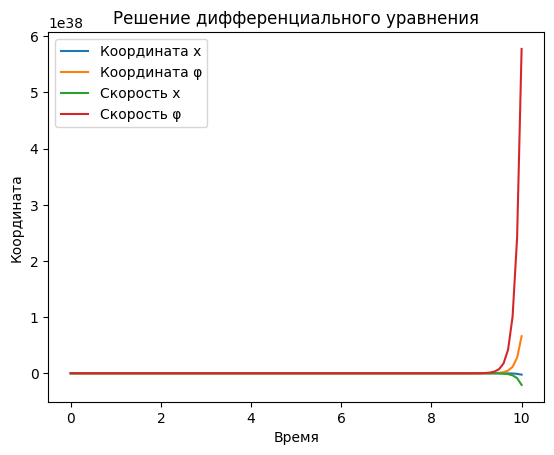

In [73]:
plt.plot(grid, solution[0, :], label='Координата x')
plt.plot(grid, solution[1, :], label='Координата φ')
plt.plot(grid, solution[2, :], label='Скорость x')
plt.plot(grid, solution[3, :], label='Скорость φ')
plt.xlabel('Время')
plt.ylabel('Координата')
plt.title('Решение дифференциального уравнения')
plt.legend()
plt.show()

In [74]:
Q = np.eye(4)
R = np.array([1])

In [75]:
P = solve_continuous_are(A, B, Q, R)
P

array([[  24.73475577,  400.73139782,   49.52826955,   45.84822838],
       [ 400.73139782, 6949.11131181,  845.8178391 ,  794.47848117],
       [  49.52826955,  845.8178391 ,  103.89653275,   96.74473378],
       [  45.84822838,  794.47848117,   96.74473378,   90.88836807]])

In [76]:
K = (1/R) * B.T @ P
K

array([[ -20.04987562, -348.5380487 ,  -42.36194399,  -39.87426441]])

In [77]:
A = A - B @ K
A

array([[   0.        ,    0.        ,    1.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    1.        ],
       [   0.89332228,   27.64782655,    1.98772835,    3.54437906],
       [  -5.35993366, -105.88695931,  -11.92637013,  -21.26627435]])

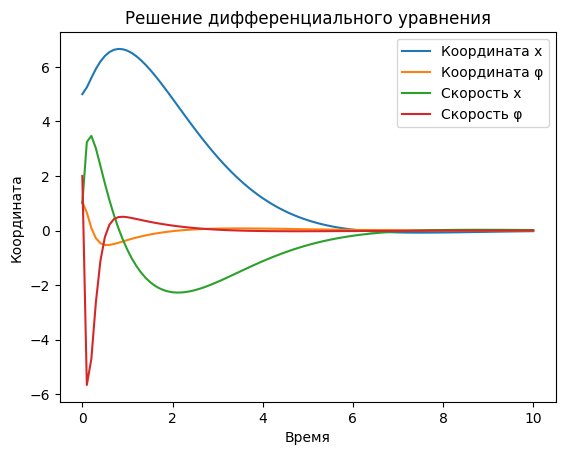

In [78]:
grid, solution = Linear_Runge_Kutta_4(0, 10, 101, A, x_0)
plt.plot(grid, solution[0, :], label='Координата x')
plt.plot(grid, solution[1, :], label='Координата φ')
plt.plot(grid, solution[2, :], label='Скорость x')
plt.plot(grid, solution[3, :], label='Скорость φ')
plt.xlabel('Время')
plt.ylabel('Координата')
plt.title('Решение дифференциального уравнения')
plt.legend()
plt.show()

In [79]:
class mech_system():
    def __init__(self, mech_params: dict, x_0: np.array, rectangle_width, rectangle_height, rod_length):
        M = mech_params['M']
        m = mech_params['m']
        c1 = mech_params['c1']
        c2 = mech_params['c2']
        b1 = mech_params['b1']
        b2 = mech_params['b2']
        g = mech_params['g']
        l = mech_params['l']
        self.A = np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [-(4*(M + m)*(c1 + c2))/((M + m)*(4*M + m)), -(3 * (M + m) * m * g)/((M + m)*(4*M + m)), -(4*(M + m)*(b1 + b2))/((M + m)*(4*M + m)), 0],
              [(6 * (M + m) * (c1 + c2))/(l * (M + m)*(4*M + m)), (3 * g) / (2 * l) + (9 * (M + m) * m * g)/(2 * l * (M + m)*(4*M + m)), (6 * (M + m) * (b1 + b2))/(l * (M + m)*(4*M + m)), 0]])
        self.B = np.array([0, 0, 4 * (M + m) / ((4 * M + m) * (M + m)), -6 * (M + m) / (l * (4 * M + m) * (M + m))]).reshape(-1, 1)
        self.x_0 = x_0
        self.rectangle_width = rectangle_width
        self.rectangle_height = rectangle_height
        self.rod_length = rod_length
    def stabilize(self):
        Q = np.eye(4) 
        R = np.array([1])
        P = solve_continuous_are(A, B, Q, R)
        K = (1/R) * B.T @ P
        self.A = A - B @ K
    @protected
    def get_state(self):
        return self.x_0[0], self.x_0[1], self.x_0[2], self.x_0[3]
    @protected
    def get_coordinates_for_animation(self):
        x_coordintate, angle, velocity, angle_velocity = self.get_state()
        center_rectangle_x = x_coordintate
        center_rectangle_y = self.rectangle_height / 2
        left_corner_rectangle_x = x_coordintate - self.rectangle_width / 2 
        left_corner_rectangle_y = 0
        rod_end_x = center_rectangle_x + self.rod_length * np.sin(angle)
        rod_end_y = self.rectangle_height / 2 + self.rod_length * np.cos(angle)
        return left_corner_rectangle_x, left_corner_rectangle_y, center_rectangle_x, center_rectangle_y, rod_end_x, rod_end_y
    def animate(self, t_0, t_end, n):
        h = (t_end - t_0) / (n - 1)
        fig, ax = plt.subplots()
        plt.grid()
        ax.set_xlim(-10, 10)
        ax.set_ylim(0, 10)
        lines = []
        for i in range(n):
            left_corner_rectangle_x, left_corner_rectangle_y, center_rectangle_x, center_rectangle_y, rod_end_x, rod_end_y = self.get_coordinates_for_animation()
            line_1 = ax.add_patch(Rectangle((left_corner_rectangle_x, left_corner_rectangle_y), rectangle_width, rectangle_height))
            line_2 = ax.add_line(Line2D([center_rectangle_x, rod_end_x], [center_rectangle_y, rod_end_y], color='red'))
            lines.append([line_1, line_2])
            k1 = self.A.dot(self.x_0)
            k2 = A.dot(self.x_0 + h * k1 / 2)
            k3 = A.dot(self.x_0 + h * k2 / 2)
            k4 = A.dot(self.x_0 + h * k3)
            self.x_0 = self.x_0 + (h / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
        ani = animation.ArtistAnimation(fig, lines, interval=50)
        ani.save('pendulum.gif', writer='imagemagick')

In [80]:
rectangle_width, rectangle_height, rod_length = 4, 2, 5
s = mech_system(parameters, x_0, rectangle_width, rectangle_height, rod_length)
s.stabilize()

MovieWriter imagemagick unavailable; using Pillow instead.


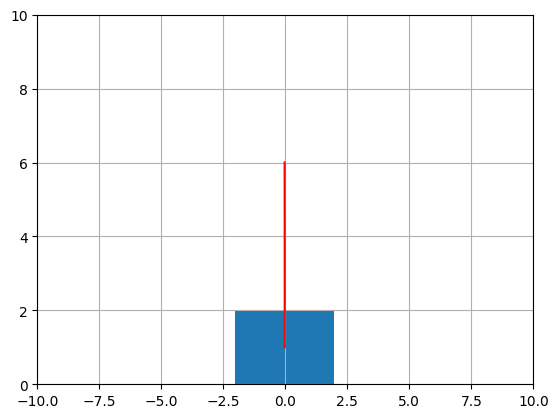

In [81]:
rectangle_width, rectangle_height, rod_length = 4, 2, 5
s.animate(0, 10, 101)